In [2]:
import numpy as np
import pandas as pd
from  scipy import optimize
import matplotlib.pyplot as plt
import warnings
import statistics
import inspect
import requests
from bs4 import BeautifulSoup
warnings.filterwarnings('ignore')

In [3]:
### CONSTANTS ###

URL = r"https://ogle.astrouw.edu.pl/ogle4/ews/2019/blg-0173.html"
DATAPATH = r"https://www.astrouw.edu.pl/ogle/ogle4/ews/2019/blg-0173/phot.dat"

URL_P3 = r"https://ogle.astrouw.edu.pl/ogle4/ews/2019/blg-0109.html"
DATAPATH_P3 = r"https://ogle.astrouw.edu.pl/ogle/ogle4/ews/2019/blg-0109/phot.dat"

CONSTANTS = {}
CONSTANTS_BCKP = {}

NUMPOINTS_SIDE = 20

In [4]:
def fetch_constants(url):
    response = requests.get(url)
    html_content = response.text
    soup = BeautifulSoup(html_content, 'html.parser')

    # Extract the metadata
    
    def create_data_dict(table):
        d = {}
        rows = table.find_all('tr')
        split_info = rows[0].get_text().split("\n\n")
        for row in split_info:
            split_row = row.strip().split()
            if len(split_row) > 1:
                if "±" not in row:
                    key = " ".join(split_row[:-1])
                    value = split_row[-1]
                    d[key] = value
                else:
                    split_row = row.strip().split("±")
                    key = split_row[0]
                    value = split_row[1].split()[0]
                    d[key] = value
        return d
    
    def parse_constants(constants_dict):
        d = {}
        for key, value in constants_dict.items():
            nkey = str.upper(key.split()[0])
            nval = float(key.split()[1])
            try:
                nerr = float(value)
            except ValueError:
                nerr = 0
            d[nkey] = (nval, nerr)
        return d


    general_info_table = soup.find_all('table')[1]
    info = create_data_dict(general_info_table)
    measurements_table = soup.find_all('table')[2]
    constants = create_data_dict(measurements_table)
    fixed_constants = parse_constants(constants)

    return info, fixed_constants

In [5]:
import sympy as sp

# Define the variables
a, b, c = sp.symbols('a b c')
sigma_a, sigma_b, sigma_c = sp.symbols('sigma_a sigma_b sigma_c')

# Define the original expression
inner_expr = c - (c - (b**2 / (4 * a)) + 1) / 2
expr = sp.sqrt(b**2 - 4 * a * inner_expr) / a

# Calculate partial derivatives
partial_a = sp.diff(expr, a)
partial_b = sp.diff(expr, b)
partial_c = sp.diff(expr, c)

# Define the uncertainty formula
uncertainty_expr = sp.sqrt((partial_a * sigma_a)**2 + (partial_b * sigma_b)**2 + (partial_c * sigma_c)**2)

# Convert the SymPy expressions into numerical functions
def calc_tau_err(a_val, a_err, b_val, b_err, c_val, c_err):
    # Substitute values into the partial derivatives
    partial_a_func = sp.lambdify((a, b, c), partial_a)
    partial_b_func = sp.lambdify((a, b, c), partial_b)
    partial_c_func = sp.lambdify((a, b, c), partial_c)

    # Compute the partial derivative values
    partial_a_val = partial_a_func(a_val, b_val, c_val)
    partial_b_val = partial_b_func(a_val, b_val, c_val)
    partial_c_val = partial_c_func(a_val, b_val, c_val)

    # Calculate the uncertainty
    uncertainty = sp.sqrt((partial_a_val * a_err)**2 + (partial_b_val * b_err)**2 + (partial_c_val * c_err)**2)
    return float(uncertainty)

In [6]:
def parse_file(file_path, delim=" "):
    df = pd.read_csv(file_path, delimiter=delim, header=None)
    return df

def gather_points(x, y, numpoints=NUMPOINTS_SIDE):
    amax = np.argmax(y)
    points = [y[amax]]
    norm_y = (y - np.min(y)) / (np.max(y) - np.min(y))
    norm_x = (x - np.min(x)) / (np.max(x) - np.min(x))
    currl = amax
    currr = amax
    while len(points) < 2 * NUMPOINTS_SIDE:
        deltal = np.linalg.norm(np.array(norm_x[amax] - norm_x[currl-1], norm_y[amax] - norm_y[currl-1]))
        deltar = np.linalg.norm(np.array(norm_x[amax] - norm_x[currr-1], norm_y[amax] - norm_y[currr-1]))
        if deltal > deltar:
            points.append(y[currr])
            currr = currr + 1
        else:
            points.append(y[currl])
            currl = currl - 1
    print("Sampling points between indexes: [{currl}, {currr}]".format(currl=currl, currr=currr))
    return currl, currr


def read_cols_I(df):
    x_full = df[0]
    y_full = df[1]
    t_start = x_full[0]
    errors_full = df[2]
    m_star = np.mean(y_full)
    print(f"m* for point selection: {m_star}")
    
    I_data = convert_m_to_I(y_full, m_star)
    
    amax = np.argmax(I_data)
    xmax = x_full[amax]
    t0_zero = xmax
    currl, currr = gather_points(x_full, I_data, NUMPOINTS_SIDE)
    baseline_data = y_full.values[:(currl // 2)]
    baseline_errors = errors_full.values[:(currl // 2)]
    # baseline_data = np.hstack((y_full.values[:currl], y_full.values[currr:]))
    # baseline_errors = np.hstack((errors_full.values[:currl], errors_full.values[currr:]))
    m_star = np.mean(baseline_data)
    print(f"m* after point selection: {m_star}")
    m_star_err = np.std(baseline_errors, ddof=1) / np.sqrt(len(baseline_errors))
    I_errors_full = convert_m_err_to_I_err(y_full, m_star, errors_full, m_star_err)
    I_data = convert_m_to_I(y_full, m_star)
    x_full = x_full - t_start
    xmax = x_full[amax]
    # Time after start of event
    t0_rel = xmax - x_full[currl]
    # Center at 0
    x_full = x_full - xmax
    x = x_full[currl:currr]
    I_data = I_data[currl:currr]
    
    I_errors = I_errors_full[currl:currr]
    
    # t0_rel unused
    return x, t0_zero, I_data, t0_rel, I_errors

def rel_err(error, value):
    return '%s' % float('%.2g' % abs((error / value) * 100))
    
def print_with_errors(params_and_errors):
    for param in params_and_errors:
            value = params_and_errors[param][0]
            error = params_and_errors[param][1]
            print(f"{param} = {value} ± {error} | Δrel = {rel_err(error, value)}%")

def fit_and_format_final(func, x, y, dy, initial_guess=None, bounds=(-np.inf, np.inf), maxfev=1000):
    params, errors = optimize.curve_fit(func, x, y, sigma=dy,absolute_sigma=True, p0=initial_guess, bounds=bounds, maxfev=maxfev)
    # Excluding the x param
    func_params = list(inspect.signature(func).parameters.keys())[1:]
    params_and_errors = dict([(key, (params[i], errors[i][i])) for i, key in enumerate(func_params)])
    # print(params_and_errors)
    params_values = dict([(key, params[i]) for i, key in enumerate(func_params)])
    chisqr = chi_square(func, x, y, dy, params_values)
    dof = len(y) - len(func_params)
    chisqr_red = chisqr/dof
    print_with_errors(params_and_errors)
    print(f"χ^2 = {chisqr}")
    print(f"χ^2_red = {chisqr_red}")
    return params_and_errors, params_values, chisqr

def fit_curve_final(func, x, y, dy, params_values, xlabel, ylabel, debug_vals=None):
    # Plot the data and the fit
    y_fit = func(x, **params_values)
    plt.figure(figsize=(8, 6))  # Adjust figure size (width, height)
    plt.errorbar(x, y, yerr=dy, fmt='o', label='Data')
    plt.plot(x, y_fit, label=f"{func.__doc__}")
    if type(debug_vals).__name__ != "NoneType":
        plt.plot(x, debug_vals, "r--", label=f"OGLE Params: {func.__doc__}")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("I/I* as a function of Time [HJD-T0]")
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)
    
    # Adjust the layout to make room for the legend
    # plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()

def chi_square(func, x, y, dy, params_values):
    return sum((y - func(x, **params_values))**2 / dy**2)

def convert_m_to_I(m, m_star):
    return 10**((m-m_star)/(-2.5))

def convert_m_err_to_I_err(m, m_star, m_err, m_star_err):
    return abs((2*(2**0.5)*np.log(10) / 5) * convert_m_to_I(m, m_star) * np.sqrt(m_err**2 + m_star_err**2))

def parabolic_func(x, a, b, c):
    y = a*x**2 + b*x + c
    return y

def nsig(a, a_err, b, b_err):
    return abs((a - b) / np.sqrt(a_err**2 + b_err**2))

def nsig_dict(a_dict, consts_dict):
    ns_dict = {}
    for key in a_dict:
        if key.upper() in consts_dict:
            a, a_err = a_dict[key]
            b, b_err = consts_dict[key.upper()]
            ns = abs((a - b) / np.sqrt(a_err**2 + b_err**2))
            ns_dict[key] = ns
    return ns_dict

def nsig_dict2(a_dict, b_dict):
    ns_dict = {}
    for key in a_dict:
        if key in b_dict:
            a, a_err = a_dict[key]
            b, b_err = b_dict[key]
            ns = abs((a - b) / np.sqrt(a_err**2 + b_err**2))
            ns_dict[key] = ns
    return ns_dict

def print_nsigmas(params_and_errors, consts_dict):
    d = nsig_dict(params_and_errors, consts_dict)
    for k, v in d.items():
        print(f"Nσ ({k}) = {v}")

def print_nsigmas2(a_dict, b_dict):
    d = nsig_dict2(a_dict, b_dict)
    for k, v in d.items():
        print(f"Nσ ({k}) = {v}")

def calc_u(mu):
    return abs(2**0.5 * np.sqrt(1 / (mu**2 + np.sqrt(mu**2 * (mu**2 - 1)) - 1)))

def calc_du(mu, d_mu):
    recip2 = mu*(np.sqrt(mu**2-1)+mu)-1
    recip1 = np.sqrt(2) * (mu**2-1)**(3/2) * np.sqrt(1 / recip2)
    return abs(- d_mu / recip1)

def calc_tau_and_err(a, b, c, a_err, b_err, c_err):
    # Assuming I/I* = 1
    # Assuming FWHM -> (I_max + 1) / 2
    I_max = c - (b**2 / (4*a))
    fwhm = (I_max + 1) / 2
    x1 = (-b + np.sqrt(b**2 - 4 * a * (c - fwhm))) / (2 * a)
    x2 = (-b - np.sqrt(b**2 - 4 * a * (c - fwhm))) / (2 * a)
    tau = abs(x1 - x2)
    # tau_err = np.sqrt((a_err*(b/a)**2)**2 + (2*b*b_err/a)**2 +(4*c_err)**2)
    tau_err = calc_tau_err(a, a_err, b, b_err, c, c_err)
    return tau, tau_err

def extract_u_t(func, a, b, c, a_err, b_err, c_err):
    t0 = -b / (2*a)
    t0_err = np.sqrt((a_err*t0/a)**2 + (b_err/(2*a))**2)
    I_max = c - (b**2 / (4*a))
    I_max_err = np.sqrt((b/(2*a) * b_err)**2 + ((b**2*a_err)/(4*a**2))**2 + c_err**2)
    print(f"I max = {I_max} ± {I_max_err}")
    umin = calc_u(I_max)
    umin_err = calc_du(I_max, I_max_err)
    tau, tau_err = calc_tau_and_err(a, b, c, a_err, b_err, c_err)
    return dict((("tmax", (t0, t0_err)), ("umin", (umin, umin_err)), ("tau", (tau, tau_err))))

def plot_residuals(x, y, errors, func, params_values, xlabel, ylabel):
    y_fit = func(x, **params_values)
    residuals = y - y_fit
    plt.plot(x, residuals, "bo")
    plt.title("Residuals Plot of I/I* as a function of Time")
    plt.xlabel(xlabel)
    if len(ylabel.split("[")) > 1:
        ylabel_raw = ylabel.split("[")[:-1]
        ylabel_units = ylabel.split("[")[-1][:-1]
        plt.ylabel(f"{ylabel_raw} - f(x) [{ylabel_units}]")
    else:
        plt.ylabel(f"{ylabel} - f(x)")
    plt.errorbar(x, residuals ,xerr=None, yerr=errors, ls='none')
    plt.axhline(0, linestyle='--')
    plt.show()

def fit_and_plot(initial_guess, func, x, y, dy, xlabel, ylabel, bounds=(-np.inf, np.inf), debug_vals=None):
    params_and_errors, params_values, chisqr = fit_and_format_final(
        func, x, y, dy, initial_guess=initial_guess, bounds=bounds, maxfev=10000)

    fit_curve_final(func, x, y, dy, params_values, xlabel=xlabel, ylabel=ylabel, debug_vals=debug_vals)
    plot_residuals(x, y, dy, func, params_values, xlabel=xlabel, ylabel=ylabel)
    return params_values, params_and_errors


# Nonlinear functions

def paczynski_curve(t, umin, tmax, tau, fbl):
    """
    I/I*(umin, tmax, tau, fbl) = fbl*µ + (1 - fbl)
    """
    u_t = np.sqrt(umin**2 + ((t - tmax) / tau)**2)
    mu = (u_t**2 + 2) / (u_t * np.sqrt(u_t**2 + 4))
    # return mu * fbl + (1 - fbl)
    return fbl* (mu - 1) + 1

def paczynski_curve_fixed(t, umin, tmax):
    """
    I/I*(umin, tmax) = µ
    """
    return paczynski_curve(t, umin, tmax, tau=CONSTANTS["TAU"][0], fbl=1)

def paczynski_curve_umin_fixed(t, tmax):
    umin = CONSTANTS["UMIN"]
    return paczynski_curve(t, umin, tmax, tau=CONSTANTS["TAU"][0], fbl=1)

In [13]:
def sim(path, datapath):
    df = parse_file(datapath)
    info, constants = fetch_constants(path)
    global CONSTANTS
    CONSTANTS = constants
    t_data, tmax, I_data, t0_rel, I_errors = read_cols_I(df)
    print(tmax)
    df = parse_file(DATAPATH)
    t_start = df[0][0]
    plt.plot(t_data, I_data, "bo")
    plt.show()
    params_and_errors, params_values, chisqr = fit_and_format_final(parabolic_func, t_data, I_data, I_errors)
    (a, a_err), (b, b_err), (c, c_err) = params_and_errors["a"], params_and_errors["b"], params_and_errors["c"]
    params_and_errors = extract_u_t(parabolic_func, a, b, c, a_err, b_err, c_err)
    print_with_errors(params_and_errors)
    constants["TMAX"] = (constants["TMAX"][0] - tmax, constants["TMAX"][1])
    print_nsigmas(params_and_errors, constants)
    
    plt.plot(t_data, parabolic_func(t_data, a, b, c), "r-")
    plt.title("I/I* Magnitude as a Function of Time")
    plt.xlabel(f"Time [HJD - {tmax}]")
    plt.ylabel("I/I* Magnitude")
    plt.errorbar(t_data, I_data ,xerr=None, yerr=I_errors, ls='none')
    plt.show()
    plot_residuals(t_data, I_data, I_errors, parabolic_func, params_values, f"Time [HJD - {tmax}]", "I/I* Magnitude")

    
    df = pd.concat([t_data.reset_index(drop=True), I_data.reset_index(drop=True), I_errors.reset_index(drop=True)], axis=1)
    df.columns = ['x', 'y', 'errors']
    T0 = []
    T0_err = []
    Umin = []
    Umin_err = []
    Tau = []
    Tau_err = []
    size = df.shape[0]
    print("num of rows: ", size)
    for i in range(10000):
        print(i)
        sim_df = df.sample(n=size, replace=True)
        sim_x = sim_df['x']
        sim_y = sim_df['y']
        sim_err = sim_df['errors']
        I_star = np.mean(sim_y)
        sim_params, params_values, chisqr = fit_and_format_final(parabolic_func, sim_x, sim_y, sim_err)
        (a, a_err), (b, b_err), (c, c_err) = sim_params["a"], sim_params["b"], sim_params["c"]
        sim_params = extract_u_t(parabolic_func, a, b, c, a_err, b_err, c_err)
        new_t0 = sim_params["tmax"][0]
        new_t_err = sim_params["tmax"][1]
        new_umin = sim_params["umin"][0]
        new_u_err = sim_params["umin"][1]
        new_tau = sim_params["tau"][0]
        new_tau_err = sim_params["tau"][1]
        new_t0 = new_t0 + tmax
        T0.append(new_t0)
        T0_err.append(new_t_err)
        Umin.append(new_umin)
        Umin_err.append(new_u_err)
        Tau.append(new_tau)
        Tau_err.append(new_tau_err)

    hist_t0, hist_t0_err = statistics.mode(T0), np.sqrt(np.var(T0))
    hist_umin, hist_umin_err = statistics.mode(Umin), np.sqrt(np.var(Umin))
    hist_tau, hist_tau_err = statistics.mode(Tau), np.sqrt(np.var(Tau))
    hist_params = {}
    hist_params["tmax"] = (hist_t0 - tmax, hist_t0_err)
    hist_params["umin"] = (hist_umin, hist_umin_err)
    hist_params["tau"] = (hist_tau, hist_tau_err)
    
    print("most freuqent values:")
    print("T0 = ", hist_t0, " ± ", hist_t0_err, " [HJD] | Δrel = ", 100*hist_t0_err/hist_t0, "%")
    print("t0 = ", hist_t0 - tmax)
    print("Umin = ", hist_umin, " ± ", hist_umin_err, " | Δrel = ", 100*hist_umin_err/hist_umin, "%")
    print("tau = ", hist_tau, " ± ", hist_tau_err, " days | Δrel = ", 100*hist_tau_err/hist_tau, "%")
    print("params and errors:")
    print("T0 = ", params_and_errors["tmax"][0], " ± ", params_and_errors["tmax"][1], " [HJD]")
    print("Umin = ", params_and_errors["umin"][0], " ± ", params_and_errors["umin"][1])
    print("tau = ", params_and_errors["tau"][0], " ± ", params_and_errors["tau"][1], " days")
    
    print_nsigmas2(hist_params, params_and_errors)

    plt.figure()
    plt.hist(T0, bins=size, alpha=0.7, label='T0')
    plt.title('Histogram of T0')
    plt.xlabel('T0 [HJD]')
    plt.ylabel('Frequency [sets of data]')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.hist(Umin, bins=size, alpha=0.7, label='Umin')
    plt.title('Histogram of Umin')
    plt.xlabel('Umin')
    plt.ylabel('Frequency [sets of data]')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.hist(Tau, bins=size, alpha=0.7, label='tau')
    plt.title('Histogram of tau')
    plt.xlabel('tau [days]')
    plt.ylabel('Frequency [sets of data]')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

m* for point selection: 19.040634839650142
Sampling points between indexes: [1926, 1965]
m* after point selection: 19.044434060228454
2458551.84599


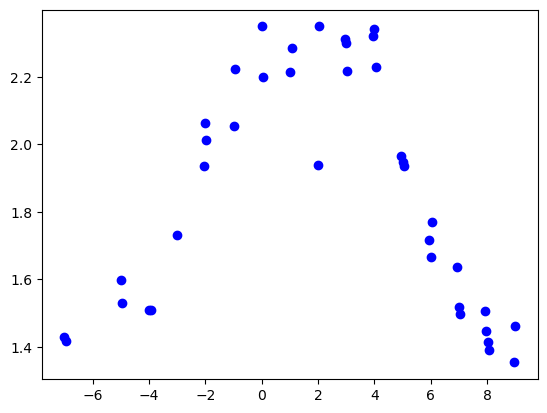

a = -0.014616570295409163 ± 2.8148823059546824e-07 | Δrel = 0.0019%
b = 0.03338948209857883 ± 7.126882208236363e-06 | Δrel = 0.021%
c = 2.165486753094703 ± 0.0003122414530043421 | Δrel = 0.014%
χ^2 = 180.0931968381254
χ^2_red = 5.002588801059039
I max = 2.184555137337371 ± 0.0003123477585794116
tmax = 1.1421790961818843 ± 0.0002447849040383836 | Δrel = 0.021%
umin = 0.4995255809757317 ± 8.534431173315809e-05 | Δrel = 0.017%
tau = 12.731216346545992 ± 0.0016831209221658924 | Δrel = 0.013%
Nσ (tmax) = 5.827592283495562
Nσ (umin) = 11.878691793699678
Nσ (tau) = 23.25884418164952


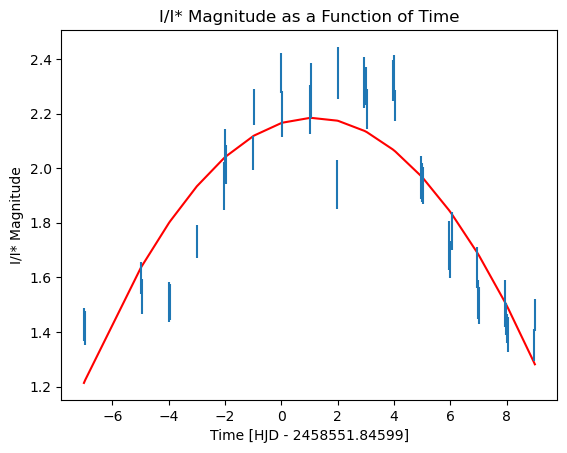

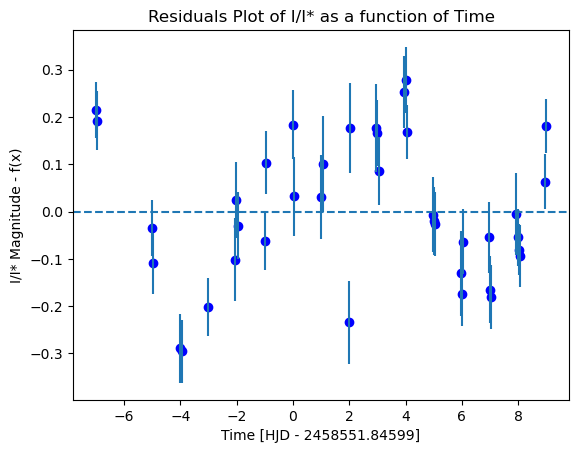

num of rows:  39
0
a = -0.015134509614070054 ± 2.9336739525781995e-07 | Δrel = 0.0019%
b = 0.0365726276619715 ± 6.447372918634906e-06 | Δrel = 0.018%
c = 2.1819766009214843 ± 0.0002889686522225606 | Δrel = 0.013%
χ^2 = 162.54766143859422
χ^2_red = 4.515212817738728
I max = 2.204071091067001 ± 0.00028907395311694126
1
a = -0.014691488363631273 ± 2.921733897642905e-07 | Δrel = 0.002%
b = 0.028824234017324854 ± 6.545451293828322e-06 | Δrel = 0.023%
c = 2.166213760509814 ± 0.00036190063463831663 | Δrel = 0.017%
χ^2 = 135.36851556027202
χ^2_red = 3.7602365433408895
I max = 2.180351818651395 ± 0.0003619577011759204
2
a = -0.01551577208868079 ± 3.2064494814300864e-07 | Δrel = 0.0021%
b = 0.045363885171774795 ± 7.69166876113357e-06 | Δrel = 0.017%
c = 2.136064399408463 ± 0.0002897354192519559 | Δrel = 0.014%
χ^2 = 176.31292296439184
χ^2_red = 4.897581193455329
I max = 2.1692223058619104 ± 0.000289954331036421
3
a = -0.014233202736604283 ± 2.6320449784172796e-07 | Δrel = 0.0018%
b = 0.032458156

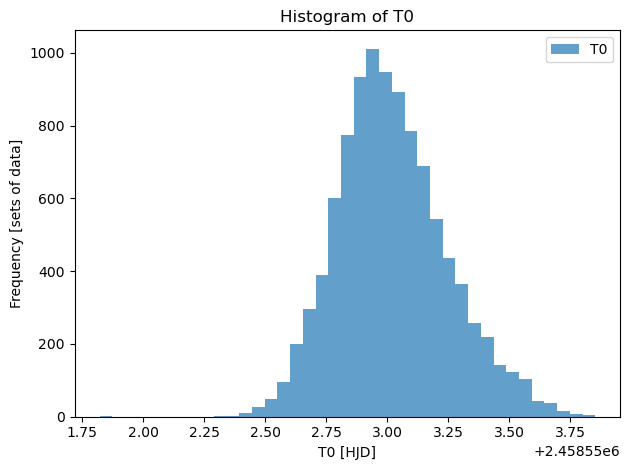

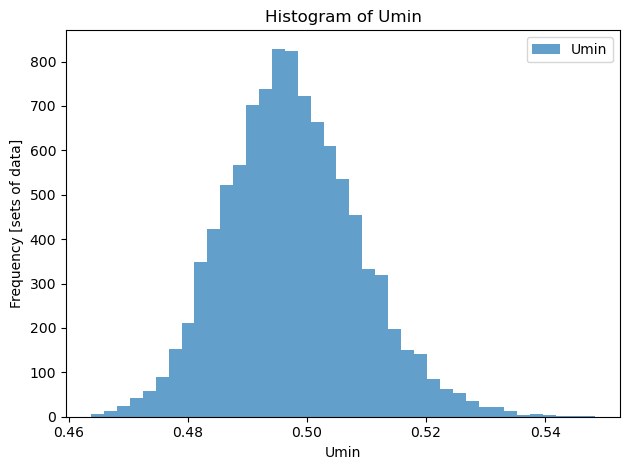

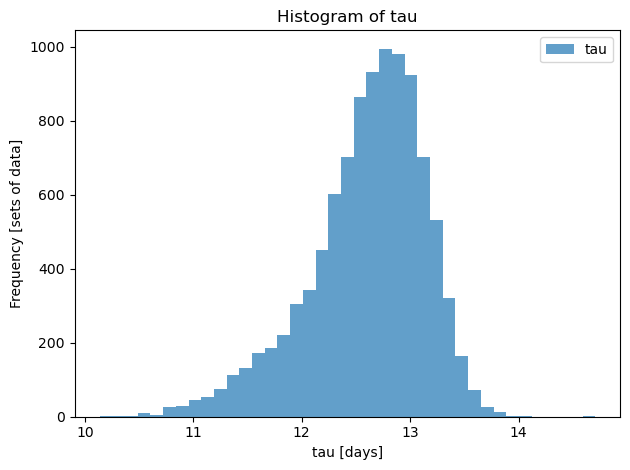

In [14]:
sim(URL, DATAPATH)

$\frac{I}{I*} = \mu = \frac{u^2+2}{u\sqrt{u^2+4}}$ ,
$u = \sqrt{u_{min}^2 + (\frac{t-T_0}{\tau})^2}$

In [15]:
def nonlinear_fit(path, datapath):
    df = parse_file(datapath)
    info, constants = fetch_constants(path)
    global CONSTANTS
    CONSTANTS = constants
    t_data, tmax, I_data, t0_rel, I_errors = read_cols_I(df)
    print("\nParabolic fit")
    params_and_errors, params_values, chisqr = fit_and_format_final(parabolic_func, t_data, I_data, I_errors)
    (a, a_err), (b, b_err), (c, c_err) = params_and_errors["a"], params_and_errors["b"], params_and_errors["c"]
    u_t_params = extract_u_t(parabolic_func, a, b, c, a_err, b_err, c_err)
    umin = u_t_params["umin"][0]
    t0 = u_t_params["tmax"][0]
    print_with_errors(u_t_params)
    constants["TMAX"] = (constants["TMAX"][0] - tmax, constants["TMAX"][1])
    print_nsigmas(u_t_params, constants)
    print("\nNonlinear fit")
    initial_guess = [umin, t0]
    params_values_fixed, params_and_errors = fit_and_plot(
        initial_guess, paczynski_curve_fixed, t_data, I_data, I_errors, xlabel=f"Time [HJD - {tmax}]", ylabel="I Magnitude")
    print("\nReal values")
    print_with_errors(constants)
    print("\nN sigmas")
    print_nsigmas(params_and_errors, constants)

m* for point selection: 19.040634839650142
Sampling points between indexes: [1926, 1965]
m* after point selection: 19.044434060228454

Parabolic fit
a = -0.014616570295409163 ± 2.8148823059546824e-07 | Δrel = 0.0019%
b = 0.03338948209857883 ± 7.126882208236363e-06 | Δrel = 0.021%
c = 2.165486753094703 ± 0.0003122414530043421 | Δrel = 0.014%
χ^2 = 180.0931968381254
χ^2_red = 5.002588801059039
I max = 2.184555137337371 ± 0.0003123477585794116
tmax = 1.1421790961818843 ± 0.0002447849040383836 | Δrel = 0.021%
umin = 0.4995255809757317 ± 8.534431173315809e-05 | Δrel = 0.017%
tau = 12.731216346545992 ± 0.0016831209221658924 | Δrel = 0.013%
Nσ (tmax) = 5.827592283495562
Nσ (umin) = 11.878691793699678
Nσ (tau) = 23.25884418164952

Nonlinear fit
umin = 0.45124526615816324 ± 2.6505075873829044e-05 | Δrel = 0.0059%
tmax = 1.47442498159211 ± 0.007078161721404385 | Δrel = 0.48%
χ^2 = 91.13644284282101
χ^2_red = 2.4631471038600274


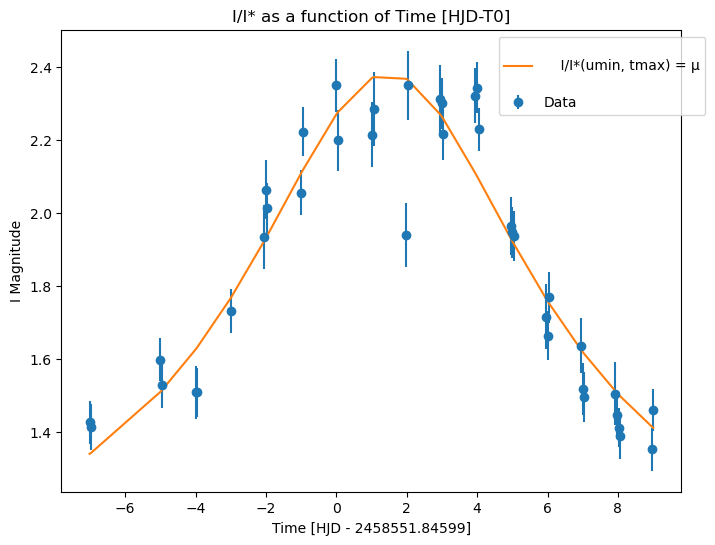

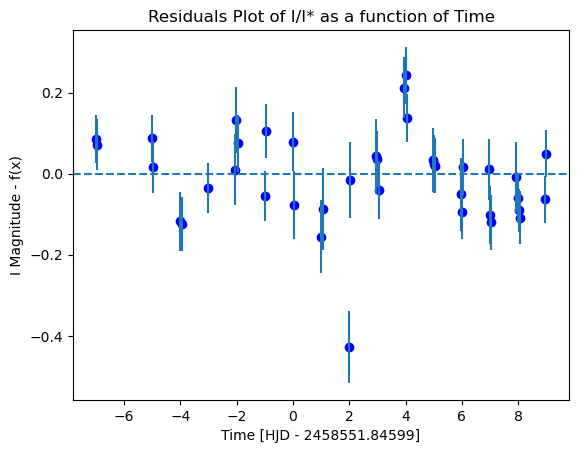


Real values
TMAX = 1.4860100001096725 ± 0.059 | Δrel = 4.0%
TAU = 9.498 ± 0.139 | Δrel = 1.5%
UMIN = 0.452 ± 0.004 | Δrel = 0.88%
AMAX = 2.376 ± 0.019 | Δrel = 0.8%
DMAG = 0.94 ± 0.001 | Δrel = 0.11%
FBL = 1.0 ± 0.0 | Δrel = 0.0%
IBL = 19.037 ± 0.001 | Δrel = 0.0053%
I0 = 19.037 ± 0.001 | Δrel = 0.0053%

N sigmas
Nσ (umin) = 0.1886793182916958
Nσ (tmax) = 0.19495828729015433


In [16]:
nonlinear_fit(URL, DATAPATH)

In [17]:
def p3(path, datapath, debug=None):
    df = parse_file(datapath)
    info, constants = fetch_constants(path)
    global CONSTANTS
    CONSTANTS = constants
    t_data, tmax, I_data, t0_rel, I_errors = read_cols_I(df)
    bounds2 = ([0, -np.inf], [np.inf, np.inf])
    bounds = ([0, -np.inf, -np.inf, 0], [np.inf, np.inf, np.inf, 1.])
    print("\nParabolic Fit")
    params_and_errors, params_values, chisqr = fit_and_format_final(parabolic_func, t_data, I_data, I_errors)
    (a, a_err), (b, b_err), (c, c_err) = params_and_errors["a"], params_and_errors["b"], params_and_errors["c"]
    u_t_params = extract_u_t(parabolic_func, a, b, c, a_err, b_err, c_err)
    umin = u_t_params["umin"][0]
    t0 = u_t_params["tmax"][0]
    tau = u_t_params["tau"][0]
    print_with_errors(u_t_params)
    constants["TMAX"] = (constants["TMAX"][0] - tmax, constants["TMAX"][1])
    print_nsigmas(u_t_params, constants)
    
    if debug:
        debug = paczynski_curve(t_data, constants["UMIN"][0], constants["TMAX"][0], constants["TAU"][0], constants["FBL"][0])
    
    initial_guess = [umin, t0]
    initial_guess4 = [umin, t0, tau, 0.5]
    print("\nNonlinear Fit (fbl = 1)")
    params_values_fixed, params_and_errors_fixed = fit_and_plot(initial_guess, paczynski_curve_fixed, t_data, I_data, I_errors,  xlabel=f"Time [HJD - {tmax}]", bounds=bounds2, ylabel="I/I*")
    print_nsigmas(params_and_errors_fixed, constants)
    print()
    print("\nNonlinear Fit (fbl != 1)")
    params_values, params_and_errors = fit_and_plot(initial_guess4, paczynski_curve, t_data, I_data, I_errors,  xlabel=f"Time [HJD - {tmax}]", ylabel="I/I*", bounds=bounds, debug_vals=debug)
    print("\nReal values")
    print_with_errors(constants)
    print("\nN sigmas")
    print_nsigmas(params_and_errors, constants)

m* for point selection: 16.963122611464968
Sampling points between indexes: [925, 964]
m* after point selection: 17.13277922077922

Parabolic Fit
a = -0.33374880053771283 ± 3.578729582013244e-07 | Δrel = 0.00011%
b = 0.08718780851341511 ± 1.819545137137207e-06 | Δrel = 0.0021%
c = 15.065918163640864 ± 0.0001755043265744947 | Δrel = 0.0012%
χ^2 = 184078.8578621483
χ^2_red = 5113.301607281897
I max = 15.07161235186051 ± 0.00017550448760430816
tmax = 0.1306189091510504 ± 2.7295159595612367e-06 | Δrel = 0.0021%
umin = 0.0664597490950339 ± 7.764697867541234e-07 | Δrel = 0.0012%
tau = 9.18284116321351 ± 5.7476704514603065e-05 | Δrel = 0.00063%
Nσ (tmax) = 61.62867951875048
Nσ (umin) = 54683.066642590675
Nσ (tau) = 221.53083717526806

Nonlinear Fit (fbl = 1)
umin = 0.04351280426307889 ± 3.445052159096373e-09 | Δrel = 7.9e-06%
tmax = 0.14873525227944936 ± 7.432640827564588e-06 | Δrel = 0.005%
χ^2 = 98966.88159847082
χ^2_red = 2674.7805837424544


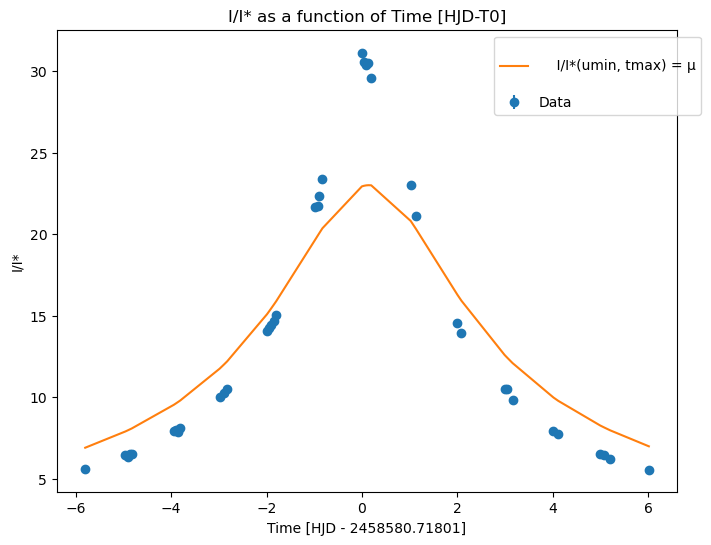

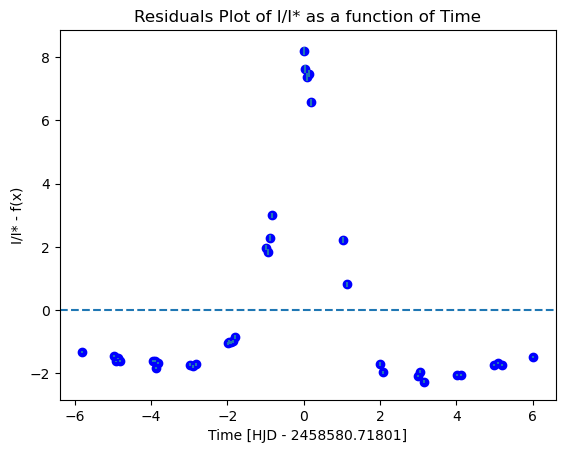

Nσ (umin) = 5664008.369672126
Nσ (tmax) = 79.74304958342091


Nonlinear Fit (fbl != 1)
umin = 0.02694717486876928 ± 7.686004602303801e-07 | Δrel = 0.0029%
tmax = 0.07015229308035115 ± 4.71012244096221e-06 | Δrel = 0.0067%
tau = 38.793202409858864 ± 1.3128734358438883 | Δrel = 3.4%
fbl = 0.8160380861314694 ± 0.0007172095571332037 | Δrel = 0.088%
χ^2 = 287.080381942382
χ^2_red = 8.2022966269252


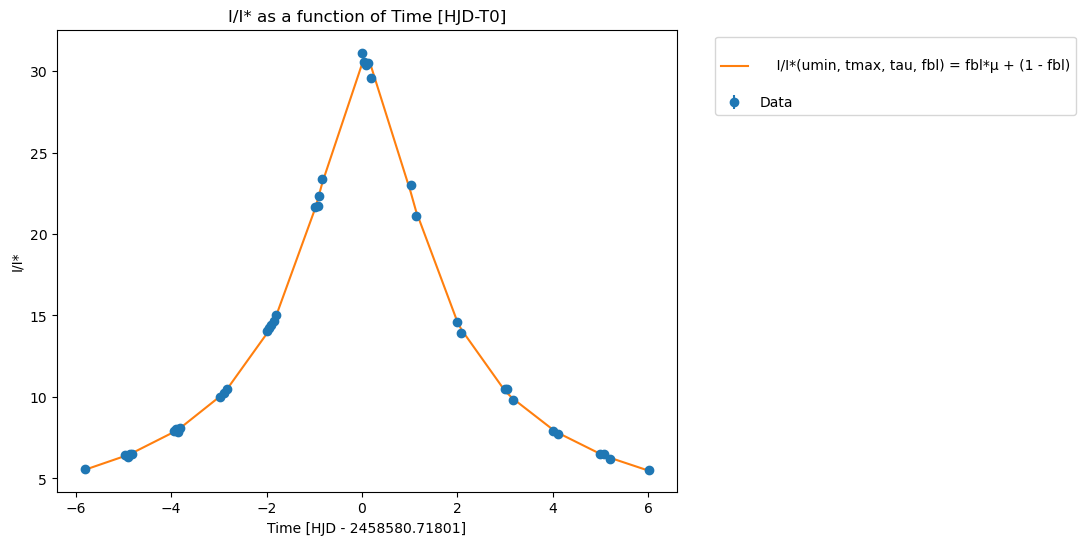

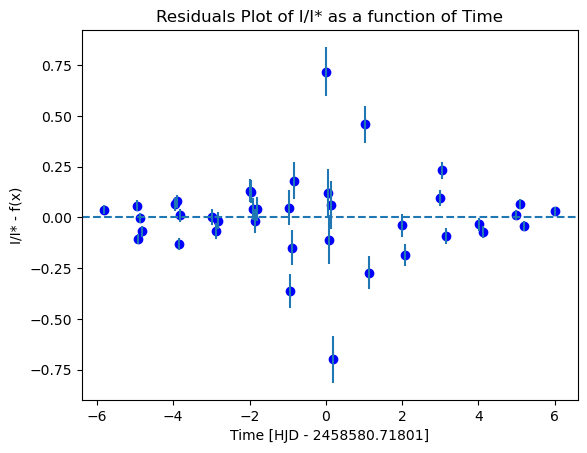


Real values
TMAX = 0.06899000005796552 ± 0.001 | Δrel = 1.4%
TAU = 42.634 ± 0.151 | Δrel = 0.35%
UMIN = 0.024 ± 0.0 | Δrel = 0.0%
AMAX = 41.15 ± 0.183 | Δrel = 0.44%
DMAG = 4.036 ± 0.0 | Δrel = 0.0%
FBL = 0.737 ± 0.003 | Δrel = 0.41%
IBL = 17.134 ± 0.0 | Δrel = 0.0%
I0 = 17.466 ± 0.005 | Δrel = 0.029%

N sigmas
Nσ (umin) = 3834.4693000650736
Nσ (tmax) = 1.1622801297175311
Nσ (tau) = 2.9063296778826655
Nσ (fbl) = 25.623942497991745


In [21]:
p3(URL_P3, DATAPATH_P3)

m* for point selection: 16.963122611464968
Sampling points between indexes: [925, 964]
m* after point selection: 17.13277922077922

Parabolic Fit
a = -0.33374880053771283 ± 3.578729582013244e-07 | Δrel = 0.00011%
b = 0.08718780851341511 ± 1.819545137137207e-06 | Δrel = 0.0021%
c = 15.065918163640864 ± 0.0001755043265744947 | Δrel = 0.0012%
χ^2 = 184078.8578621483
χ^2_red = 5113.301607281897
I max = 15.07161235186051 ± 0.00017550448760430816
tmax = 0.1306189091510504 ± 2.7295159595612367e-06 | Δrel = 0.0021%
umin = 0.0664597490950339 ± 7.764697867541234e-07 | Δrel = 0.0012%
tau = 9.18284116321351 ± 5.7476704514603065e-05 | Δrel = 0.00063%
Nσ (tmax) = 61.62867951875048
Nσ (umin) = 54683.066642590675
Nσ (tau) = 221.53083717526806

Nonlinear Fit (fbl = 1)
umin = 0.04351280426307889 ± 3.445052159096373e-09 | Δrel = 7.9e-06%
tmax = 0.14873525227944936 ± 7.432640827564588e-06 | Δrel = 0.005%
χ^2 = 98966.88159847082
χ^2_red = 2674.7805837424544


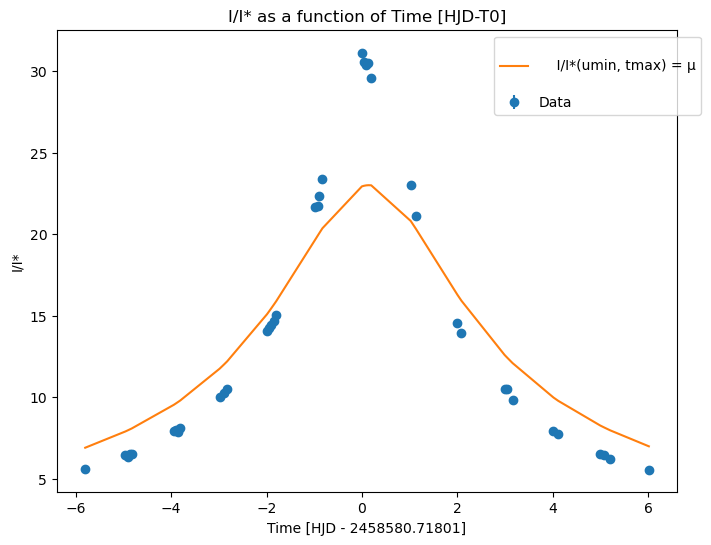

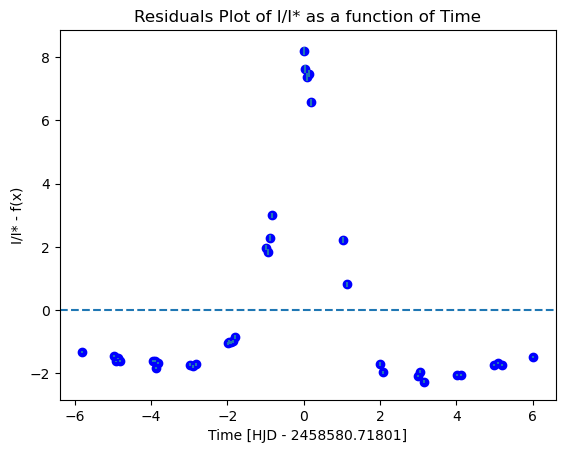

Nσ (umin) = 5664008.369672126
Nσ (tmax) = 79.74304958342091


Nonlinear Fit (fbl != 1)
umin = 0.02694717486876928 ± 7.686004602303801e-07 | Δrel = 0.0029%
tmax = 0.07015229308035115 ± 4.71012244096221e-06 | Δrel = 0.0067%
tau = 38.793202409858864 ± 1.3128734358438883 | Δrel = 3.4%
fbl = 0.8160380861314694 ± 0.0007172095571332037 | Δrel = 0.088%
χ^2 = 287.080381942382
χ^2_red = 8.2022966269252


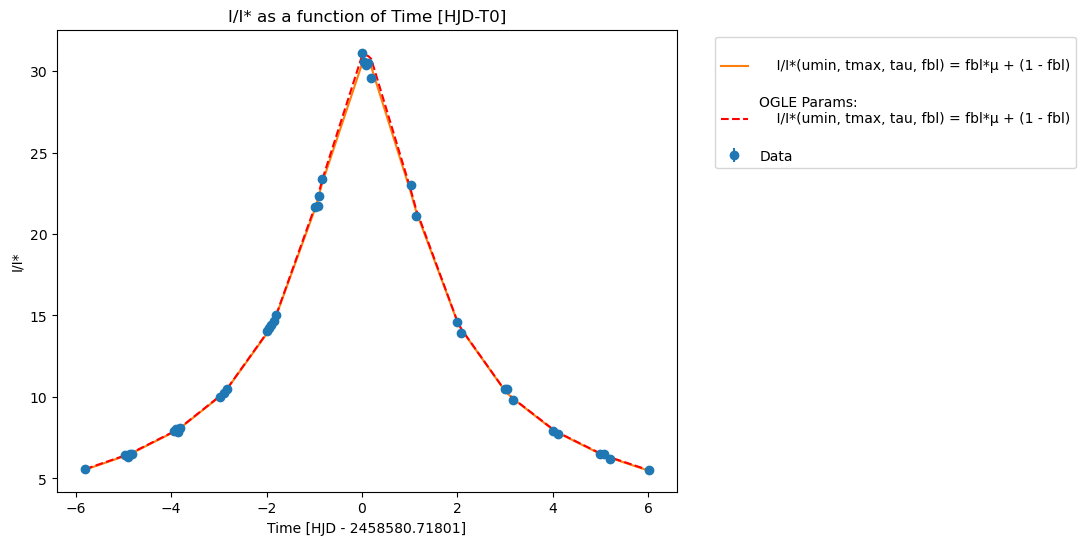

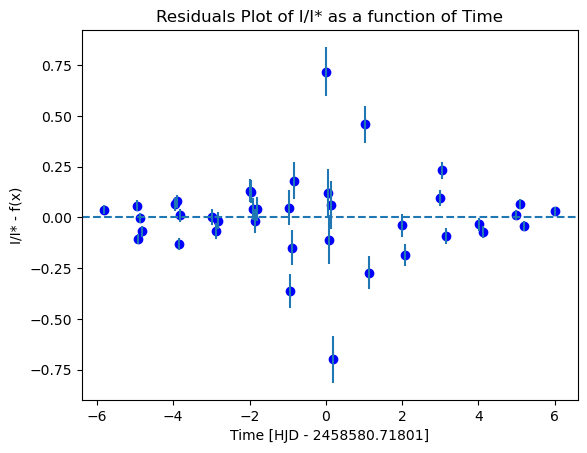


Real values
TMAX = 0.06899000005796552 ± 0.001 | Δrel = 1.4%
TAU = 42.634 ± 0.151 | Δrel = 0.35%
UMIN = 0.024 ± 0.0 | Δrel = 0.0%
AMAX = 41.15 ± 0.183 | Δrel = 0.44%
DMAG = 4.036 ± 0.0 | Δrel = 0.0%
FBL = 0.737 ± 0.003 | Δrel = 0.41%
IBL = 17.134 ± 0.0 | Δrel = 0.0%
I0 = 17.466 ± 0.005 | Δrel = 0.029%

N sigmas
Nσ (umin) = 3834.4693000650736
Nσ (tmax) = 1.1622801297175311
Nσ (tau) = 2.9063296778826655
Nσ (fbl) = 25.623942497991745


In [22]:
p3(URL_P3, DATAPATH_P3, debug=True)

In [266]:
def chi_square_mesh(x, y, errors, array1, array2, umin_mesh, t0_mesh, tau_mesh, fbl_mesh, chi_square_grid):
    N = len(array1)
    for i in range(N):
        for j in range(N):
            chi_square_grid[i, j] = chi_square(paczynski_curve, x, y, errors, {"umin": umin_mesh[i, j], "tmax": t0_mesh[i, j], "tau": tau_mesh[i, j], "fbl": fbl_mesh[i, j]})

    chi_min_idx = np.argmin(chi_square_grid)
    idx1, idx2 = np.unravel_index(chi_min_idx, chi_square_grid.shape)
    
    min1 = array1[idx1]
    min2 = array2[idx2]

    return min1, min2, chi_square_grid, idx1, idx2

def chi_square_fixed(x, y, errors, array1, array2, umin_mesh, t0_mesh, chi_square_grid):
    N = len(array1)
    for i in range(N):
        for j in range(N):
            chi_square_grid[i, j] = chi_square(paczynski_curve_fixed, x, y, errors, {"umin": umin_mesh[i, j], "tmax": t0_mesh[i, j]})

    chi_min_idx = np.argmin(chi_square_grid)
    idx1, idx2 = np.unravel_index(chi_min_idx, chi_square_grid.shape)
    
    min1 = array1[idx1]
    min2 = array2[idx2]

    return min1, min2, chi_square_grid, idx1, idx2

def chi_square_4d(x, y, errors, u_array, t_array, tau_array, f_array, umin_mesh, t0_mesh, tau_mesh, fbl_mesh, chi_square_grid, N, params, p_errors):
    for i in range(N):
        print(i)
        if u_array[i] < params[0] - 0.75*p_errors[0] or u_array[i] > params[0] + 0.5*p_errors[0]:
            chi_booli = 0
        else:
            chi_booli = 1
        for j in range(N):
            if t_array[j] < params[1] - 0.5*p_errors[1] or t_array[j] > params[1] + 0.5*p_errors[1]:
                chi_boolj = 0
            else:
                chi_boolj = 1
            print(i, ",", j)
            for k in range(N):
                if tau_array[k] < params[2] - 0.5*p_errors[2] or tau_array[k] > params[2] + 4:
                    chi_boolk = 0
                else:
                    chi_boolk = 1
                for l in range(N):
                    if f_array[l] < 0.7 or f_array[l] > 0.9:
                        chi_booll = 0
                    else:
                        chi_booll = 1
                    if chi_booli == 0 or chi_boolj == 0 or chi_boolk == 0 or chi_booll == 0:
                        chi_square_grid[i, j, k , l] = np.inf
                    else:
                        chi_square_grid[i , j, k ,l] = chi_square(paczynski_curve, x, y, errors, {"umin": umin_mesh[i, j, k, l], "tmax": t0_mesh[i, j, k, l], "tau": tau_mesh[i, j, k, l], "fbl": fbl_mesh[i, j, k, l]})
        # np.savez_compressed('chi_square_4d_fbl.npz', chi_square_4d=chi_square_grid)
    np.savez_compressed('chi_square_4d_fbl.npz', chi_square_4d=chi_square_grid)
    chi_min_idx = np.argmin(chi_square_grid)
    u_idx, t_idx, tau_idx, f_idx = np.unravel_index(chi_min_idx, chi_square_grid.shape)

    u_min, t_min, tau_min, f_min = u_array[u_idx], t_array[t_idx], tau_array[tau_idx], f_array[f_idx]

    return u_min, t_min, tau_min, f_min, chi_square_grid, u_idx, t_idx, tau_idx, f_idx

def chi_square_4d_fbl1(x, y, errors, u_array, t_array, tau_array, f_array, umin_mesh, t0_mesh, tau_mesh, fbl_mesh, chi_square_grid, N, params, p_errors):
    for i in range(N):
        print(i)
        if u_array[i] < 0.4 or u_array[i] > 0.6:
            chi_booli = 0
        else:
            chi_booli = 1
        for j in range(N):
            if t_array[j] < params[1] - 0.5*p_errors[1] or t_array[j] > params[1] + 0.5*p_errors[1]:
                chi_boolj = 0
            else:
                chi_boolj = 1
            print(i, ",", j)
            for k in range(N):
                if tau_array[k] < params[2] - 0.5*p_errors[2] or tau_array[k] > params[2] + 0.5*p_errors[2]:
                    chi_boolk = 0
                else:
                    chi_boolk = 1
                for l in range(N):
                    if f_array[l] < 0.8:
                        chi_booll = 0
                    else:
                        chi_booll = 1
                    if chi_booli == 0 or chi_boolj == 0 or chi_boolk == 0 or chi_booll == 0:
                        chi_square_grid[i, j, k , l] = np.inf
                    else:
                        chi_square_grid[i , j, k ,l] = chi_square(paczynski_curve, x, y, errors, {"umin": umin_mesh[i, j, k, l], "tmax": t0_mesh[i, j, k, l], "tau": tau_mesh[i, j, k, l], "fbl": fbl_mesh[i, j, k, l]})
        # np.savez_compressed('chi_square_4d_fbl.npz', chi_square_4d=chi_square_grid)
    np.savez_compressed('chi_square_4d_fbl1.npz', chi_square_4d=chi_square_grid)
    chi_min_idx = np.argmin(chi_square_grid)
    u_idx, t_idx, tau_idx, f_idx = np.unravel_index(chi_min_idx, chi_square_grid.shape)

    u_min, t_min, tau_min, f_min = u_array[u_idx], t_array[t_idx], tau_array[tau_idx], f_array[f_idx]

    return u_min, t_min, tau_min, f_min, chi_square_grid, u_idx, t_idx, tau_idx, f_idx

m* for point selection: 19.040634839650124
Sampling points between indexes: [1926, 1965]
m* after point selection: 19.044434060228454
u:  0.4530609345110852  ±  0.006060606060606072  | Δrel =  1.3377021938883995 %
t:  1.4582533333262409  ±  0.13650999999972013  | Δrel =  9.361199242956236 %
chi[t, u] =  91.31770883060987
t nsigma:  0.18664407873120126
u nsigma:  0.14610187724511411
xmax: 2458551.84599


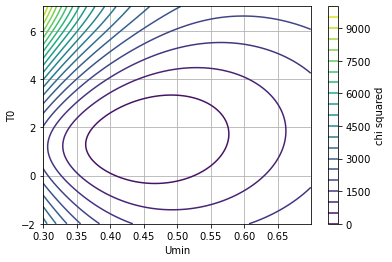

In [346]:
t0 = 1.1421790961818843
t0_err = 0.0002447849040383836
umin = 0.4995255809757317
umin_err = 0.00008534431173315809

info, constants = fetch_constants(URL)
global CONSTANTS
CONSTANTS = constants

N = 100

df = parse_file(DATAPATH)
t_start = df[0][0]

# xmax is x at the peak (data - t_start)
x, xmax, y, t0_rel, errors = read_cols_I(df)
X = x.to_numpy()
Y = y.to_numpy()
err = errors.to_numpy()
# start
umin_min = umin - 0.2
T0_min = -2
# stop
umin_max = umin + 0.2
T0_max = t0_rel

umin_array = np.linspace(umin_min, umin_max, N)
T0_array = np.linspace(T0_min, T0_max, N)
umin_mesh, t0_mesh = np.meshgrid(umin_array, T0_array)
chi_square_grid = np.empty([N, N])

u_min, t0_min, chi_square_grid, umin_idx, t0_idx = chi_square_fixed(X, Y, err, umin_array, T0_array, umin_mesh, t0_mesh, chi_square_grid)

chi_min = chi_square_grid[t0_idx, umin_idx]

i = j = k = l = 0
while t0_idx + i < 99 and chi_square_grid[t0_idx + i, umin_idx] - chi_min < 1:
    i += 1
while t0_idx - j > 0 and chi_square_grid[t0_idx - j, umin_idx] - chi_min < 1:
    j += 1
while umin_idx + k < 99 and chi_square_grid[t0_idx, umin_idx + k] - chi_min < 1:
    k += 1
while umin_idx - l > 0 and chi_square_grid[t0_idx, umin_idx - l] - chi_min < 1:
    l += 1

delta_t_pos = abs(T0_array[t0_idx + i] - t0_min)
delta_t_neg = abs(t0_min - T0_array[t0_idx - j])
delta_u_pos = abs(umin_array[umin_idx + k] - u_min)
delta_u_neg = abs(u_min - umin_array[umin_idx - l])

t0_error = (delta_t_pos + delta_t_neg) / 2
umin_error = (delta_u_neg + delta_u_pos) / 2


print("u: ", u_min, " ± ", umin_error, " | Δrel = ", 100*umin_error/u_min, "%")
print("t: ", t0_min, " ± ", t0_error, " | Δrel = ", 100*t0_error/t0_min, "%")
print("chi[t, u] = ", chi_min)


T0_nsigma = nsig(t0_min, t0_error, CONSTANTS['TMAX'][0], CONSTANTS['TMAX'][1])
Umin_nsigma = nsig(u_min, umin_error, CONSTANTS['UMIN'][0], CONSTANTS['UMIN'][1])

print("t nsigma: ", T0_nsigma)
print("u nsigma: ", Umin_nsigma)
print("xmax:", xmax)

plt.figure()
levels = np.arange(0, np.max(chi_square_grid) + 500, 500)
contour = plt.contour(umin_mesh, t0_mesh, chi_square_grid, levels=levels)
plt.colorbar(contour, label='chi squared')
plt.xlabel('Umin')
plt.ylabel('T0')
plt.grid(True)
plt.show()

m* for point selection: 19.040634839650124
Sampling points between indexes: [1926, 1965]
m* after point selection: 19.044434060228454


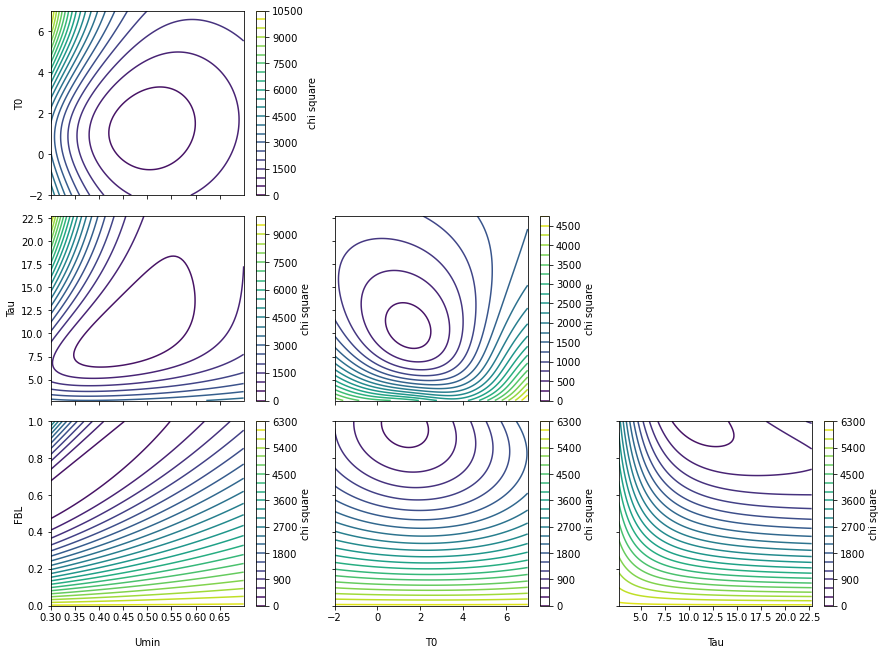

In [326]:
t0 = 1.1421790961818843
t0_err = 0.0002447849040383836
umin = 0.4995255809757317
umin_err = 0.00008534431173315809
tau = 12.731216346545992
tau_err = 0.0016831209221658924

N = 100

df = parse_file(DATAPATH)
t_start = df[0][0]

# xmax is x at the peak (data - t_start)
x, xmax, y, t0_rel, errors = read_cols_I(df)
X = x.to_numpy()
Y = y.to_numpy()
err = errors.to_numpy()

umin_min = umin - 0.2
T0_min = -2
tau_min = tau - 10
# stop
umin_max = umin + 0.2
T0_max = t0_rel
tau_max = tau + 10

umin_array = np.linspace(umin_min, umin_max, N)
T0_array = np.linspace(T0_min, T0_max, N)
tau_array = np.linspace(tau_min, tau_max, N)
fbl_array = np.linspace(0, 1, N)

umin_array_fixed = np.array([umin for i in range(N)])
T0_array_fixed = np.array([t0 for i in range(N)])
tau_array_fixed = np.array([tau for i in range(N)])
fbl_array_fixed = np.array([1 for i in range(N)])

umin_mesh_t, t0_mesh_u = np.meshgrid(umin_array, T0_array)
umin_mesh_tau, tau_mesh_u = np.meshgrid(umin_array, tau_array)
umin_mesh_f, fbl_mesh_u = np.meshgrid(umin_array, fbl_array)
fbl_mesh_tau, tau_mesh_f = np.meshgrid(fbl_array, tau_array)
fbl_mesh_t, t0_mesh_f = np.meshgrid(fbl_array, T0_array)
tau_mesh_t, t0_mesh_tau = np.meshgrid(tau_array, T0_array)
umin_mesh_fixed, t0_mesh_fixed = np.meshgrid(umin_array_fixed, T0_array_fixed)
fbl_mesh_fixed, tau_mesh_fixed = np.meshgrid(fbl_array_fixed, tau_array_fixed)

chi_square_grid_ut = np.empty([N, N])
chi_square_grid_ttau = np.empty([N, N])
chi_square_grid_utau = np.empty([N, N])
chi_square_grid_ft = np.empty([N, N])
chi_square_grid_fu = np.empty([N, N])
chi_square_grid_ftau = np.empty([N, N])

params = ['Umin', 'T0', 'Tau', 'FBL']
# t0 v u
t0_min_u, u_min_t, chi_square_grid_ut, t0_idx_u, umin_idx_t = chi_square_mesh(X, Y, err, T0_array, umin_array, umin_mesh_t, t0_mesh_u, tau_mesh_fixed, fbl_mesh_fixed, chi_square_grid_ut)
# t0 v tau
t0_min_tau, tau_min_t, chi_square_grid_ttau, t0_idx_tau, tau_idx_t = chi_square_mesh(X, Y, err, T0_array, tau_array, umin_mesh_fixed, t0_mesh_tau, tau_mesh_t, fbl_mesh_fixed, chi_square_grid_ttau)
# tau v u
u_min_tau, tau_min_u, chi_square_grid_utau, umin_idx_tau, tau_idx_u = chi_square_mesh(X, Y, err, umin_array, tau_array, umin_mesh_tau, t0_mesh_fixed, tau_mesh_u, fbl_mesh_fixed, chi_square_grid_utau)
# fbl v u
f_min_u, u_min_f, chi_square_grid_fu, fbl_idx_u, umin_idx_f = chi_square_mesh(X, Y, err, fbl_array, umin_array, umin_mesh_f, t0_mesh_fixed, tau_mesh_fixed, fbl_mesh_u, chi_square_grid_fu)
# fbl v tau
f_min_tau, tau_min_f, chi_square_grid_ftau, fbl_idxta_u, tau_idx_fbl = chi_square_mesh(X, Y, err, fbl_array, tau_array, umin_mesh_fixed, t0_mesh_fixed, tau_mesh_f, fbl_mesh_tau, chi_square_grid_ftau)
# fbl v t0
f_min_t, t0_min_f, chi_square_grid_ft, fbl_idx_t, t_idx_fbl = chi_square_mesh(X, Y, err, fbl_array, T0_array, umin_mesh_fixed, t0_mesh_f, tau_mesh_fixed, fbl_mesh_t, chi_square_grid_ft)

chi_grids = {(0, 1): chi_square_grid_ut, (0, 2): chi_square_grid_utau, (0, 3): chi_square_grid_fu, (1, 2): chi_square_grid_ttau, (1, 3): chi_square_grid_ft, (2, 3): chi_square_grid_ftau}

n = len(params)


data_grids = {'Umin': {'T0': umin_mesh_t, 'Tau': umin_mesh_tau, 'FBL': umin_mesh_f}, 'T0': {'Umin': t0_mesh_u, 'Tau': t0_mesh_tau, 'FBL': t0_mesh_f}, 'Tau': {'Umin': tau_mesh_u, 'T0': tau_mesh_t, 'FBL': tau_mesh_f}, 'FBL': {'Umin': fbl_mesh_u, 'T0': fbl_mesh_t, 'Tau': fbl_mesh_tau}}

def plot_contour(ax, x, y, z):
    levels = np.arange(np.min(z), np.max(z), np.max(z)/10)
    contour = ax.contour(x, y, z, levels=20)
    plt.colorbar(contour, ax=ax, label='chi square')
    plt.grid(True)

fig, axes = plt.subplots(n, n, figsize=(16, 12), sharex='col', sharey='row')

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        if i > j:
            chi_grid = chi_grids.get((j, i), None)
            if chi_grid is not None:
                plot_contour(ax, data_grids.get(params[j]).get(params[i]), data_grids.get(params[i]).get(params[j]), chi_grid)
                if i == n - 1:
                    ax.set_xlabel(params[j], labelpad=15)
                if j == 0:
                    ax.set_ylabel(params[i])
        else:
            ax.set_visible(False)

plt.tight_layout()
plt.show()


In [267]:
umin_mesh_4d, t0_mesh_4d, tau_mesh_4d, fbl_mesh_4d = np.meshgrid(umin_array, T0_array, tau_array, fbl_array)

N = 100

initial_params = [umin, t0, tau, 1]
initial_errors = [0.2, 3, 10, 0.1]
chi_square_grid_4d = np.empty([N, N, N, N])
u_min, t_min, tau_min, f_min, chi_square_grid_4d, u_idx, t_idx, tau_idx, f_idx = chi_square_4d_fbl1(x, y, errors, umin_array, T0_array, tau_array, fbl_array, umin_mesh_4d, t0_mesh_4d, tau_mesh_4d, fbl_mesh_4d, chi_square_grid_4d, N, initial_params, initial_errors)


0
0 , 0
0 , 1
0 , 2
0 , 3
0 , 4
0 , 5
0 , 6
0 , 7
0 , 8
0 , 9
0 , 10
0 , 11
0 , 12
0 , 13
0 , 14
0 , 15
0 , 16
0 , 17
0 , 18
0 , 19
0 , 20
0 , 21
0 , 22
0 , 23
0 , 24
0 , 25
0 , 26
0 , 27
0 , 28
0 , 29
0 , 30
0 , 31
0 , 32
0 , 33
0 , 34
0 , 35
0 , 36
0 , 37
0 , 38
0 , 39
0 , 40
0 , 41
0 , 42
0 , 43
0 , 44
0 , 45
0 , 46
0 , 47
0 , 48
0 , 49
0 , 50
0 , 51
0 , 52
0 , 53
0 , 54
0 , 55
0 , 56
0 , 57
0 , 58
0 , 59
0 , 60
0 , 61
0 , 62
0 , 63
0 , 64
0 , 65
0 , 66
0 , 67
0 , 68
0 , 69
0 , 70
0 , 71
0 , 72
0 , 73
0 , 74
0 , 75
0 , 76
0 , 77
0 , 78
0 , 79
0 , 80
0 , 81
0 , 82
0 , 83
0 , 84
0 , 85
0 , 86
0 , 87
0 , 88
0 , 89
0 , 90
0 , 91
0 , 92
0 , 93
0 , 94
0 , 95
0 , 96
0 , 97
0 , 98
0 , 99
1
1 , 0
1 , 1
1 , 2
1 , 3
1 , 4
1 , 5
1 , 6
1 , 7
1 , 8
1 , 9
1 , 10
1 , 11
1 , 12
1 , 13
1 , 14
1 , 15
1 , 16
1 , 17
1 , 18
1 , 19
1 , 20
1 , 21
1 , 22
1 , 23
1 , 24
1 , 25
1 , 26
1 , 27
1 , 28
1 , 29
1 , 30
1 , 31
1 , 32
1 , 33
1 , 34
1 , 35
1 , 36
1 , 37
1 , 38
1 , 39
1 , 40
1 , 41
1 , 42
1 , 43
1 , 44
1

In [269]:

# umin_mesh_4d, t0_mesh_4d, tau_mesh_4d, fbl_mesh_4d = np.meshgrid(umin_array, T0_array, tau_array, fbl_array)
info, constants = fetch_constants(URL)
global CONSTANTS
CONSTANTS = constants

umin = CONSTANTS['UMIN'][0]
umin_err = CONSTANTS['UMIN'][1]
t0 = CONSTANTS['TMAX'][0]
t0_err = CONSTANTS['TMAX'][1]
tau = CONSTANTS['TAU'][0]
tau_err = CONSTANTS['TAU'][1]
fbl = CONSTANTS['FBL'][0]
fbl_err = CONSTANTS['FBL'][1]

chi_4d = np.load('chi_square_4d_fbl1.npz')['chi_square_4d']

chi_min_idx = np.argmin(chi_4d)
u_idx, t_idx, tau_idx, f_idx = np.unravel_index(chi_min_idx, chi_4d.shape)

u_min, t_min, tau_min, f_min = umin_array[u_idx], T0_array[t_idx], tau_array[tau_idx], fbl_array[f_idx]

chi_min = np.min(chi_4d)

i = j = 0
while t_idx + i < 99 and chi_4d[u_idx, t_idx + i, tau_idx, f_idx] - chi_min < 2.3:
    i += 1
print("chi (t+) =", chi_4d[u_idx, t_idx + i, tau_idx, f_idx])
while t_idx - j > 0 and chi_4d[u_idx, t_idx - j, tau_idx, f_idx] - chi_min < 2.3:
    j += 1
print("chi (t-) =", chi_4d[u_idx, t_idx - j, tau_idx, f_idx])
delta_t_pos = abs(T0_array[t_idx + i] - t_min)
delta_t_neg = abs(t_min - T0_array[t_idx - j])
print("t idx:", t_idx, ", i, j:", i, j)

i = j = 0
while u_idx + i < 99 and chi_4d[u_idx + i, t_idx, tau_idx, f_idx] - chi_min < 2.3:
    i += 1
print("chi (u+) =", chi_4d[u_idx + i, t_idx, tau_idx, f_idx])
while u_idx - j > 0 and chi_4d[u_idx - j, t_idx, tau_idx, f_idx] - chi_min < 2.3:
    j += 1
print("chi (u-) =", chi_4d[u_idx - j, t_idx, tau_idx, f_idx])
delta_u_pos = abs(umin_array[u_idx + i] - u_min)
delta_u_neg = abs(u_min - umin_array[u_idx - j])
print("u idx:", u_idx, ", i, j:", i, j)

i = j = 0
while tau_idx + i < 99 and chi_4d[u_idx, t_idx, tau_idx + i, f_idx] - chi_min < 2.3:
    i += 1
print("chi (tau+) =", chi_4d[u_idx, t_idx, tau_idx + i, f_idx])
while tau_idx - j > 0 and chi_4d[u_idx, t_idx, tau_idx - j, f_idx] - chi_min < 2.3:
    j += 1
print("chi (tau-) =", chi_4d[u_idx, t_idx, tau_idx - j, f_idx])
delta_tau_pos = abs(tau_array[tau_idx + i] - tau_min)
delta_tau_neg = abs(tau_min - tau_array[tau_idx - j])
print("tau idx:", tau_idx, ", i, j:", i, j)

i = j = 0
while f_idx + i < 99 and chi_4d[u_idx, t_idx, tau_idx, f_idx + i] - chi_min < 2.3:
    i += 1
print("chi (f+) =", chi_4d[u_idx, t_idx, tau_idx, f_idx + i])
while f_idx - j > 0 and chi_4d[u_idx, t_idx, tau_idx, f_idx - j] - chi_min < 2.3:
    j += 1
print("chi (f-) =", chi_4d[u_idx, t_idx, tau_idx, f_idx - j])
delta_f_pos = abs(fbl_array[f_idx + i] - f_min)
delta_f_neg = abs(f_min - fbl_array[f_idx - j])
print("f idx:", f_idx, ", i, j:", i, j)

t0_error = (delta_t_pos + delta_t_neg) / 2
umin_error = (delta_u_neg + delta_u_pos) / 2
tau_error = (delta_tau_pos + delta_tau_neg) / 2
fbl_error = (delta_f_pos + delta_f_neg) / 2

t0_error_max = max(delta_t_pos, delta_t_neg)
umin_error_max = max(delta_u_neg, delta_u_pos)
tau_error_max = max(delta_tau_pos, delta_tau_neg)
fbl_error_max = max(delta_f_pos, delta_f_neg)

print("Umin = ", u_min, " ± ", umin_error, "| Δrel =", 100*umin_error/u_min)
print("T0 = ", t_min, " ± ", t0_error, "| Δrel =", 100*t0_error/t_min)
print("Tau = ", tau_min, " ± ", tau_error, "| Δrel =", 100*tau_error/tau_min)
print("FBL = ", f_min, " ± ", fbl_error, "| Δrel =", 100*fbl_error/f_min)

T0_nsigma = nsig(t_min, t0_error, t0, t0_err)
Umin_nsigma = nsig(u_min, umin_error, umin, umin_err)
Tau_nsigma = nsig(tau_min, tau_error, tau, tau_err)
FBL_nsigma = nsig(f_min, fbl_error, fbl, fbl_err)

T0_nsigma_max = nsig(t_min, t0_error_max, t0, t0_err)
Umin_nsigma_max = nsig(u_min, umin_error_max, umin, umin_err)
Tau_nsigma_max = nsig(tau_min, tau_error_max, tau, tau_err)
FBL_nsigma_max = nsig(f_min, fbl_error_max, fbl, fbl_err)

print("chi min = ",  chi_min)
print("T0 nsigma: ", T0_nsigma)
print("Umin nsigma: ", Umin_nsigma)
print("Tau nsigma: ", Tau_nsigma)
print("FBL nsigma: ", FBL_nsigma)

chi (t+) = 93.80833910068002
chi (t-) = 93.99516260835792
t idx: 36 , i, j: 2 2
chi (u+) = 95.18760639387453
chi (u-) = 96.74718528705374
u idx: 38 , i, j: 2 2
chi (tau+) = 96.37975168972453
chi (tau-) = 95.90350941572896
tau idx: 34 , i, j: 2 2
chi (f+) = 93.84246651925393
chi (f-) = 93.88564017696582
f idx: 97 , i, j: 2 2
Umin =  0.4530609345110852  ±  0.008080808080808077 | Δrel = 1.7836029251845287
T0 =  1.276239999993281  ±  0.1820133333329601 | Δrel = 14.261685367479341
Tau =  9.59990321523286  ±  0.40404040404040487 | Δrel = 4.208796640775344
FBL =  0.9797979797979799  ±  0.020202020202020166 | Δrel = 2.0618556701030886
chi min =  91.32138460879403
T0 nsigma:  1.096337786695693
Umin nsigma:  0.11766430890058437
Tau nsigma:  0.23849188038294356
FBL nsigma:  0.9999999999999972


m* for point selection: 16.963122611464982
Sampling points between indexes: [925, 964]
m* after point selection: 17.13277922077922


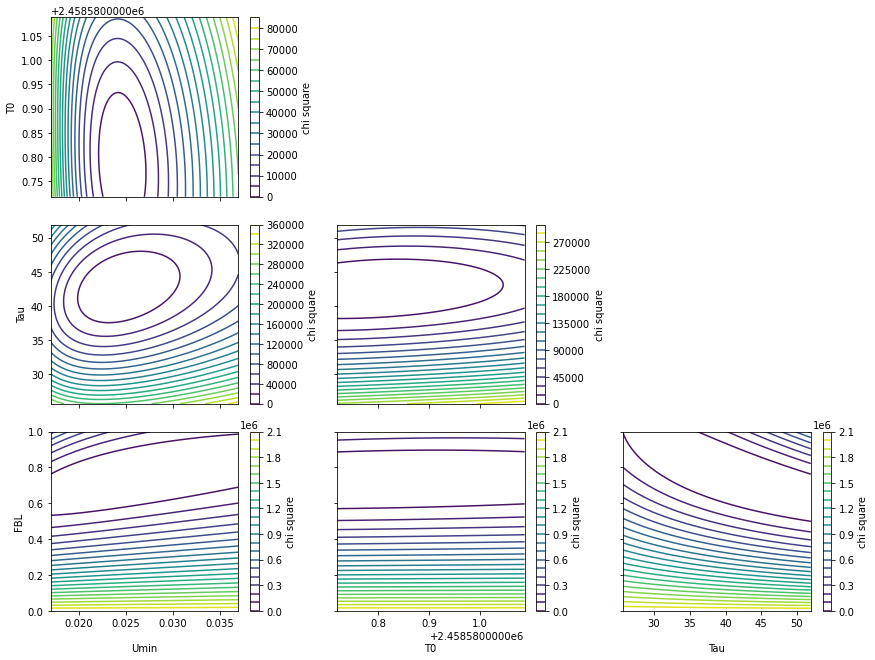

In [325]:
info, constants = fetch_constants(URL_P3)
global CONSTANTS
CONSTANTS = constants

umin = CONSTANTS['UMIN'][0]
t0 = CONSTANTS['TMAX'][0]
tau = CONSTANTS['TAU'][0]
FBL = CONSTANTS['FBL'][0]
# nl = output of nonlinear fit
umin_nl = 0.02694717361573644
umin_nl_err = 0.0000007686003365544428
t0_nl = 0.0701522922233022
t0_nl_err = 0.000004710122464377458
tau_nl = 38.79320404903746
tau_nl_err = 1.3128734928116375
FBL_nl = 0.8160380477923981

N = 100

df = parse_file(DATAPATH_P3)
t_start = df[0][0]

# xmax is x at the peak (data - t_start)
x, xmax, y, t0_rel, errors = read_cols_I(df)
X = x.to_numpy()
Y = y.to_numpy()
err = errors.to_numpy()

umin_min = umin_nl - 0.01
T0_min = 0
tau_min = tau_nl - 10*tau_nl_err

umin_max = umin_nl + 0.01
T0_max = t0_nl + 0.3
tau_max = tau_nl + 10*tau_nl_err

umin_array = np.linspace(umin_min, umin_max, N)
T0_array = np.linspace(T0_min, T0_max, N)
tau_array = np.linspace(tau_min, tau_max, N)
fbl_array = np.linspace(0, 1, N)

umin_array_fixed = np.array([umin for i in range(N)])
T0_array_fixed = np.array([t0 for i in range(N)])
tau_array_fixed = np.array([tau for i in range(N)])
fbl_array_fixed = np.array([FBL for i in range(N)])

umin_mesh_t, t0_mesh_u = np.meshgrid(umin_array, T0_array)
umin_mesh_tau, tau_mesh_u = np.meshgrid(umin_array, tau_array)
umin_mesh_f, fbl_mesh_u = np.meshgrid(umin_array, fbl_array)
fbl_mesh_tau, tau_mesh_f = np.meshgrid(fbl_array, tau_array)
fbl_mesh_t, t0_mesh_f = np.meshgrid(fbl_array, T0_array)
tau_mesh_t, t0_mesh_tau = np.meshgrid(tau_array, T0_array)
umin_mesh_fixed, t0_mesh_fixed = np.meshgrid(umin_array_fixed, T0_array_fixed)
fbl_mesh_fixed, tau_mesh_fixed = np.meshgrid(fbl_array_fixed, tau_array_fixed)

chi_square_grid_ut = np.empty([N, N])
chi_square_grid_ttau = np.empty([N, N])
chi_square_grid_utau = np.empty([N, N])
chi_square_grid_ft = np.empty([N, N])
chi_square_grid_fu = np.empty([N, N])
chi_square_grid_ftau = np.empty([N, N])

params = ['Umin', 'T0', 'Tau', 'FBL']
# data = pd.DataFrame({'Umin': umin_array, 'T0': T0_array, 'Tau': tau_array, 'FBL': fbl_array})
# t0 v u
t0_min_u, u_min_t, chi_square_grid_ut, t0_idx_u, umin_idx_t = chi_square_mesh(X, Y, err, T0_array, umin_array, umin_mesh_t, t0_mesh_u, tau_mesh_fixed, fbl_mesh_fixed, chi_square_grid_ut)
# t0 v tau
t0_min_tau, tau_min_t, chi_square_grid_ttau, t0_idx_tau, tau_idx_t = chi_square_mesh(X, Y, err, T0_array, tau_array, umin_mesh_fixed, t0_mesh_tau, tau_mesh_t, fbl_mesh_fixed, chi_square_grid_ttau)
# tau v u
u_min_tau, tau_min_u, chi_square_grid_utau, umin_idx_tau, tau_idx_u = chi_square_mesh(X, Y, err, umin_array, tau_array, umin_mesh_tau, t0_mesh_fixed, tau_mesh_u, fbl_mesh_fixed, chi_square_grid_utau)
# fbl v u
f_min_u, u_min_f, chi_square_grid_fu, fbl_idx_u, umin_idx_f = chi_square_mesh(X, Y, err, fbl_array, umin_array, umin_mesh_f, t0_mesh_fixed, tau_mesh_fixed, fbl_mesh_u, chi_square_grid_fu)
# fbl v tau
f_min_tau, tau_min_f, chi_square_grid_ftau, fbl_idx_tau, tau_idx_fbl = chi_square_mesh(X, Y, err, fbl_array, tau_array, umin_mesh_fixed, t0_mesh_fixed, tau_mesh_f, fbl_mesh_tau, chi_square_grid_ftau)
# fbl v t0
f_min_t, t0_min_f, chi_square_grid_ft, fbl_idx_t, t_idx_fbl = chi_square_mesh(X, Y, err, fbl_array, T0_array, umin_mesh_fixed, t0_mesh_f, tau_mesh_fixed, fbl_mesh_t, chi_square_grid_ft)

chi_grids = {(0, 1): chi_square_grid_ut, (0, 2): chi_square_grid_utau, (0, 3): chi_square_grid_fu, (1, 2): chi_square_grid_ttau, (1, 3): chi_square_grid_ft, (2, 3): chi_square_grid_ftau}

n = len(params)

t0_mesh_u = t0_mesh_u + xmax
t0_mesh_f = t0_mesh_f + xmax
t0_mesh_tau = t0_mesh_tau + xmax

data_grids = {'Umin': {'T0': umin_mesh_t, 'Tau': umin_mesh_tau, 'FBL': umin_mesh_f}, 'T0': {'Umin': t0_mesh_u, 'Tau': t0_mesh_tau, 'FBL': t0_mesh_f}, 'Tau': {'Umin': tau_mesh_u, 'T0': tau_mesh_t, 'FBL': tau_mesh_f}, 'FBL': {'Umin': fbl_mesh_u, 'T0': fbl_mesh_t, 'Tau': fbl_mesh_tau}}

def plot_contour(ax, x, y, z):
    levels = np.linspace(np.min(z), np.max(z), 15)
    contour = ax.contour(x, y, z, levels=20)
    plt.colorbar(contour, ax=ax, label='chi square')
    plt.grid(True)

fig, axes = plt.subplots(n, n, figsize=(16, 12), sharex='col', sharey='row')

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        if i > j:
            chi_grid = chi_grids.get((j, i), None)
            if chi_grid is not None:
                plot_contour(ax, data_grids.get(params[j]).get(params[i]), data_grids.get(params[i]).get(params[j]), chi_grid)
                if i == n - 1:
                    ax.set_xlabel(params[j], labelpad=15)
                if j == 0:
                    ax.set_ylabel(params[i])
        else:
            ax.set_visible(False)

plt.tight_layout()
plt.show()


In [166]:
umin_mesh_4d, t0_mesh_4d, tau_mesh_4d, fbl_mesh_4d = np.meshgrid(umin_array, T0_array, tau_array, fbl_array)

N = 100

initial_params = [umin_nl, t0_nl, tau_nl, FBL_nl]
initial_errors = [0.01, 0.3, 7*tau_nl_err, 0.1]
chi_square_grid_4d = np.empty([N, N, N, N])
u_min, t_min, tau_min, f_min, chi_square_grid_4d, u_idx, t_idx, tau_idx, f_idx = chi_square_4d(x, y, errors, umin_array, T0_array, tau_array, fbl_array, umin_mesh_4d, t0_mesh_4d, tau_mesh_4d, fbl_mesh_4d, chi_square_grid_4d, N, initial_params, initial_errors)


0
0 , 0
0 , 1
0 , 2
0 , 3
0 , 4
0 , 5
0 , 6
0 , 7
0 , 8
0 , 9
0 , 10
0 , 11
0 , 12
0 , 13
0 , 14
0 , 15
0 , 16
0 , 17
0 , 18
0 , 19
0 , 20
0 , 21
0 , 22
0 , 23
0 , 24
0 , 25
0 , 26
0 , 27
0 , 28
0 , 29
0 , 30
0 , 31
0 , 32
0 , 33
0 , 34
0 , 35
0 , 36
0 , 37
0 , 38
0 , 39
0 , 40
0 , 41
0 , 42
0 , 43
0 , 44
0 , 45
0 , 46
0 , 47
0 , 48
0 , 49
0 , 50
0 , 51
0 , 52
0 , 53
0 , 54
0 , 55
0 , 56
0 , 57
0 , 58
0 , 59
0 , 60
0 , 61
0 , 62
0 , 63
0 , 64
0 , 65
0 , 66
0 , 67
0 , 68
0 , 69
0 , 70
0 , 71
0 , 72
0 , 73
0 , 74
0 , 75
0 , 76
0 , 77
0 , 78
0 , 79
0 , 80
0 , 81
0 , 82
0 , 83
0 , 84
0 , 85
0 , 86
0 , 87
0 , 88
0 , 89
0 , 90
0 , 91
0 , 92
0 , 93
0 , 94
0 , 95
0 , 96
0 , 97
0 , 98
0 , 99
1
1 , 0
1 , 1
1 , 2
1 , 3
1 , 4
1 , 5
1 , 6
1 , 7
1 , 8
1 , 9
1 , 10
1 , 11
1 , 12
1 , 13
1 , 14
1 , 15
1 , 16
1 , 17
1 , 18
1 , 19
1 , 20
1 , 21
1 , 22
1 , 23
1 , 24
1 , 25
1 , 26
1 , 27
1 , 28
1 , 29
1 , 30
1 , 31
1 , 32
1 , 33
1 , 34
1 , 35
1 , 36
1 , 37
1 , 38
1 , 39
1 , 40
1 , 41
1 , 42
1 , 43
1 , 44
1

In [167]:

# umin_mesh_4d, t0_mesh_4d, tau_mesh_4d, fbl_mesh_4d = np.meshgrid(umin_array, T0_array, tau_array, fbl_array)
info, constants = fetch_constants(URL_P3)
global CONSTANTS
CONSTANTS = constants

umin = CONSTANTS['UMIN'][0]
umin_err = CONSTANTS['UMIN'][1]
t0 = CONSTANTS['TMAX'][0]
t0_err = CONSTANTS['TMAX'][1]
tau = CONSTANTS['TAU'][0]
tau_err = CONSTANTS['TAU'][1]
fbl = CONSTANTS['FBL'][0]
fbl_err = CONSTANTS['FBL'][1]

chi_4d = np.load('chi_square_4d_fbl.npz')['chi_square_4d']

chi_min_idx = np.argmin(chi_4d)
u_idx, t_idx, tau_idx, f_idx = np.unravel_index(chi_min_idx, chi_4d.shape)

u_min, t_min, tau_min, f_min = umin_array[u_idx], T0_array[t_idx], tau_array[tau_idx], fbl_array[f_idx]

chi_min = np.min(chi_4d)

i = j = 0
while t_idx + i < 99 and chi_4d[u_idx, t_idx + i, tau_idx, f_idx] - chi_min < 2.3:
    i += 1
print("chi (t+) =", chi_4d[u_idx, t_idx + i, tau_idx, f_idx])
while t_idx - j > 0 and chi_4d[u_idx, t_idx - j, tau_idx, f_idx] - chi_min < 2.3:
    j += 1
print("chi (t-) =", chi_4d[u_idx, t_idx - j, tau_idx, f_idx])
delta_t_pos = abs(T0_array[t_idx + i] - t_min)
delta_t_neg = abs(t_min - T0_array[t_idx - j])
print("t idx:", t_idx, ", i, j:", i, j)

i = j = 0
while u_idx + i < 99 and chi_4d[u_idx + i, t_idx, tau_idx, f_idx] - chi_min < 2.3:
    i += 1
print("chi (u+) =", chi_4d[u_idx + i, t_idx, tau_idx, f_idx])
while u_idx - j > 0 and chi_4d[u_idx - j, t_idx, tau_idx, f_idx] - chi_min < 2.3:
    j += 1
print("chi (u-) =", chi_4d[u_idx - j, t_idx, tau_idx, f_idx])
delta_u_pos = abs(umin_array[u_idx + i] - u_min)
delta_u_neg = abs(u_min - umin_array[u_idx - j])
print("u idx:", u_idx, ", i, j:", i, j)

i = j = 0
while tau_idx + i < 99 and chi_4d[u_idx, t_idx, tau_idx + i, f_idx] - chi_min < 2.3:
    i += 1
print("chi (tau+) =", chi_4d[u_idx, t_idx, tau_idx + i, f_idx])
while tau_idx - j > 0 and chi_4d[u_idx, t_idx, tau_idx - j, f_idx] - chi_min < 2.3:
    j += 1
print("chi (tau-) =", chi_4d[u_idx, t_idx, tau_idx - j, f_idx])
delta_tau_pos = abs(tau_array[tau_idx + i] - tau_min)
delta_tau_neg = abs(tau_min - tau_array[tau_idx - j])
print("tau idx:", tau_idx, ", i, j:", i, j)

i = j = 0
while f_idx + i < 99 and chi_4d[u_idx, t_idx, tau_idx, f_idx + i] - chi_min < 2.3:
    i += 1
print("chi (f+) =", chi_4d[u_idx, t_idx, tau_idx, f_idx + i])
while f_idx - j > 0 and chi_4d[u_idx, t_idx, tau_idx, f_idx - j] - chi_min < 2.3:
    j += 1
print("chi (f-) =", chi_4d[u_idx, t_idx, tau_idx, f_idx - j])
delta_f_pos = abs(fbl_array[f_idx + i] - f_min)
delta_f_neg = abs(f_min - fbl_array[f_idx - j])
print("f idx:", f_idx, ", i, j:", i, j)

t0_error = (delta_t_pos + delta_t_neg) / 2
umin_error = (delta_u_neg + delta_u_pos) / 2
tau_error = (delta_tau_pos + delta_tau_neg) / 2
fbl_error = (delta_f_pos + delta_f_neg) / 2

t0_error_max = max(delta_t_pos, delta_t_neg)
umin_error_max = max(delta_u_neg, delta_u_pos)
tau_error_max = max(delta_tau_pos, delta_tau_neg)
fbl_error_max = max(delta_f_pos, delta_f_neg)

print("Umin = ", u_min, " ± ", umin_error)
print("T0 = ", t_min, " ± ", t0_error)
print("Tau = ", tau_min, " ± ", tau_error)
print("FBL = ", f_min, " ± ", fbl_error)

T0_nsigma = nsig(t_min, t0_error, t0, t0_err)
Umin_nsigma = nsig(u_min, umin_error, umin, umin_err)
Tau_nsigma = nsig(tau_min, tau_error, tau, tau_err)
FBL_nsigma = nsig(f_min, fbl_error, fbl, fbl_err)

T0_nsigma_max = nsig(t_min, t0_error_max, t0, t0_err)
Umin_nsigma_max = nsig(u_min, umin_error_max, umin, umin_err)
Tau_nsigma_max = nsig(tau_min, tau_error_max, tau, tau_err)
FBL_nsigma_max = nsig(f_min, fbl_error_max, fbl, fbl_err)

print("chi min = ",  chi_min)
print("T0 nsigma: ", T0_nsigma)
print("Umin nsigma: ", Umin_nsigma)
print("Tau nsigma: ", Tau_nsigma)
print("FBL nsigma: ", FBL_nsigma)

chi (t+) = 306.86309343659667
chi (t-) = 318.3215553530489
t idx: 53 , i, j: 1 1
chi (u+) = 292.03311740909595
chi (u-) = 290.7434605548981
u idx: 19 , i, j: 1 1
chi (tau+) = 363.46538473095404
chi (tau-) = 357.71868970097086
tau idx: 46 , i, j: 1 1
chi (f+) = 606.3124065205575
chi (f-) = 577.8614181311145
f idx: 83 , i, j: 1 1
Umin =  0.020785557454120276  ±  0.00020202020202020332
T0 =  0.19816233826095975  ±  0.003738912042659623
Tau =  37.86490966018075  ±  0.2652269682447752
FBL =  0.8383838383838385  ±  0.010101010101010055
chi min =  288.14744502236624
T0 nsigma:  33.37500926204281
Umin nsigma:  15.911490602104536
Tau nsigma:  15.626173459561624
FBL nsigma:  9.621610401247747
